In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import datetime as dt
from datetime import date, timedelta

import numpy as np
import pandas as pd
from scipy import stats

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True) 


In [5]:
# We can view all of the classes that automap found
Base.classes.keys() 


['measurement', 'station']

In [6]:
# Let's look at it another way and see our columns
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])
print("-----")
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

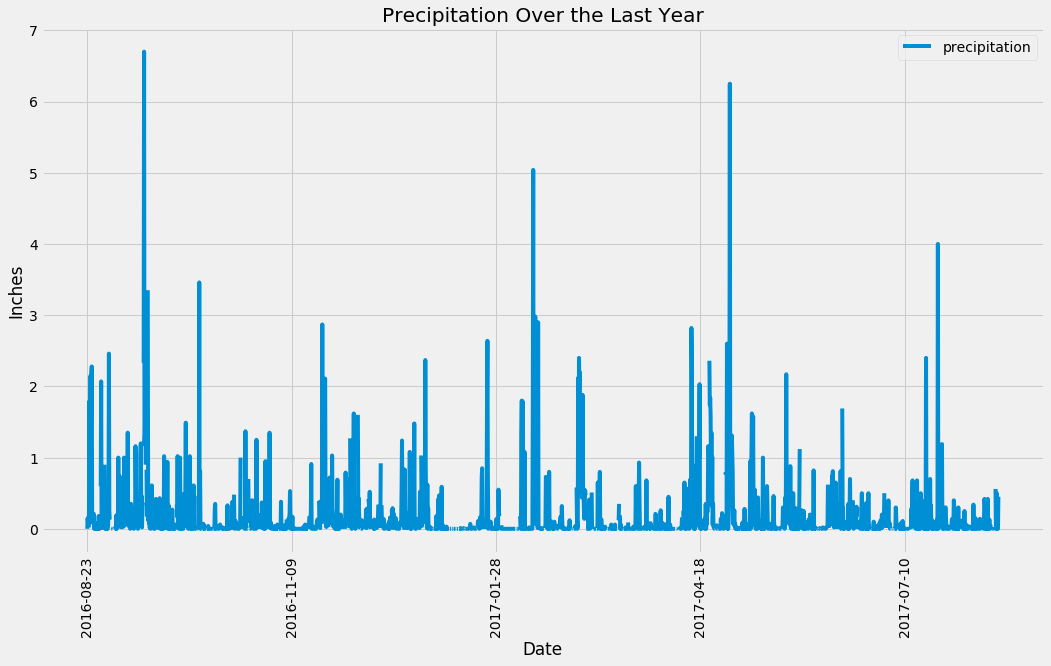

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 

# Strip the last date to a datetime object
date_strip = dt.datetime.strptime(last_date[0], '%Y-%m-%d').date()

# Pull out last year, month, and day
# Find the date a year before that and save as query_date
query_date = dt.date(date_strip.year,date_strip.month,date_strip.day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_rainfall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_rainfall, columns=['date','prcp'])
last_year_df.set_index('date', inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot.line(figsize=(16,9),title='Precipitation Over the Last Year', x_compat=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'],loc='best')

plt.xticks(rotation=90)

plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [11]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

# Can also use:
#session.query(Station).distinct(Station.station).count()

[(9)]

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all() 

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Analysis: Station with highest # of observations = USC00519281 with 2772 entries

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Get the first station's id from station_activity
station_id = station_activity[0][0]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

results = session.query(*sel).filter(Measurement.station == station_id).all()

# Print results
print(f'For station {station_id}, \
min temp= {results[0][0]}, \
max temp= {results[0][1]}, \
and avg temp= {round(results[0][2],2)}.')

For station USC00519281, min temp= 54.0, max temp= 85.0, and avg temp= 71.66.


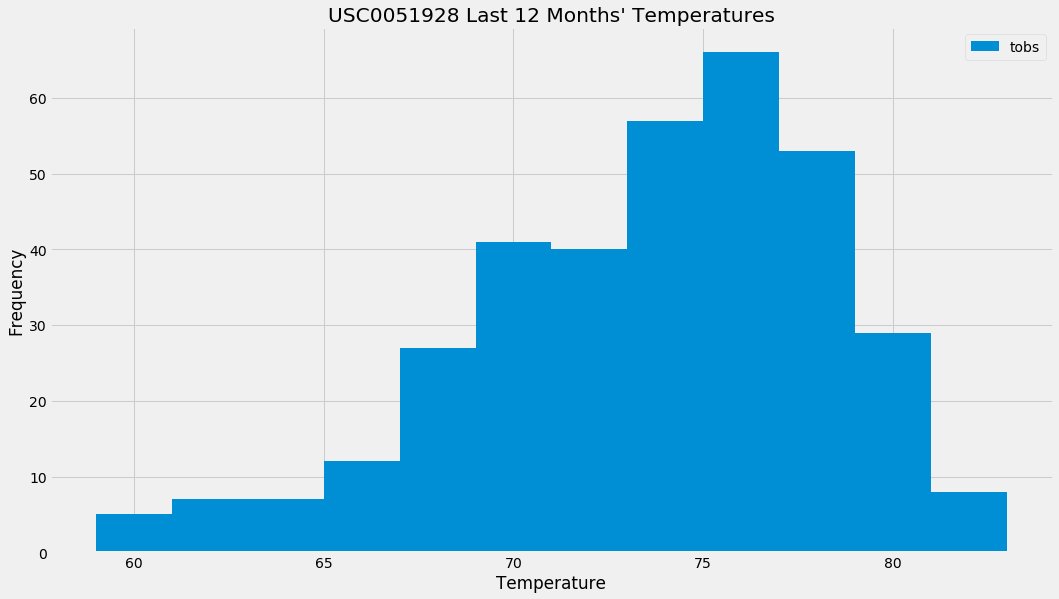

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC00519281_last_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == station_id).all()
USC00519281_last_year


USC00519281_df = pd.DataFrame(USC00519281_last_year, columns=['date','tobs'])

USC00519281_df.plot.hist(figsize=(16,9), bins=12, title='USC0051928 Last 12 Months\' Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'],loc='best')
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?<br><br>
You may either use SQLAlchemy or pandas's read_csv() to perform this portion.<br><br>
Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.<br><br>
Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?





In [15]:
june_averages = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()

december_averages = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()

ttest = stats.ttest_rel(june_averages, december_averages)
pval = ttest[1][0]
print(pval)

0.00011759380231523222


#### Conclusion:<br>
First off, statistical analysis is, by far, my weakness.<br>

I used a paired t-test since this the the same group (locations) being measured twice (well, multiple times and averaged), but under different circumstances (time of the year).<br>

The null hypothesis would be that there is no relationship between the two variables being studied and a low p-value would be an indicator that I should reject the null hypothesis and accept that there is a relationship.<br>

Therefore, I've found that these means are significantly related.<br>

### Temperature Analysis II

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-05-20', '2016-06-12')
trip_temps

[(64.0, 74.24489795918367, 81.0)]

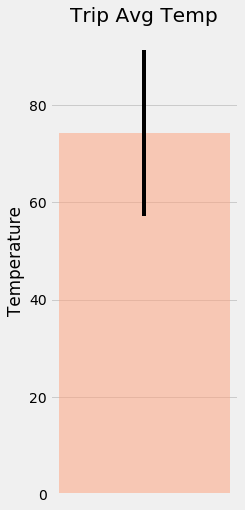

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min = trip_temps[0][0]
avg = trip_temps[0][1]
max = trip_temps[0][2]

error = max - min

plt.figure(figsize=(3,8))
plt.bar(1, avg, yerr=error, alpha=0.5, color='lightsalmon')
plt.title('Trip Avg Temp')
plt.xticks([],[])
plt.ylabel('Temperature')
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates
#     using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the
#     station, name, latitude, longitude, and elevation

# Set date variables
trip_start = '2016-05-20'
trip_end = '2016-06-12'

# Set up query seletion
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

# Query, join, and sort
results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start, Measurement.date <= trip_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

# Pretty print it
pp.pprint(results)

[   ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
    ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
    ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
    (   'USC00519523',
        'WAIMANALO EXPERIMENTAL FARM, HI US',
        21.33556,
        -157.71139,
        19.5),
    (   'USC00514830',
        'KUALOA RANCH HEADQUARTERS 886.9, HI US',
        21.5213,
        -157.8374,
        7.0),
    ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
    ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [58]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates

trip_s = date(2016, 5, 20)
trip_e = date(2016, 6, 12)

delta = trip_e - trip_s

date_list = []
for i in range(delta.days + 1):
    day = trip_s + timedelta(days=i)
    date_list.append(day.strftime("%m-%d"))
    
date_list   

#new_list                   
# Loop through the list of %m-%d strings and calculate the normals for each date



['05-20',
 '05-21',
 '05-22',
 '05-23',
 '05-24',
 '05-25',
 '05-26',
 '05-27',
 '05-28',
 '05-29',
 '05-30',
 '05-31',
 '06-01',
 '06-02',
 '06-03',
 '06-04',
 '06-05',
 '06-06',
 '06-07',
 '06-08',
 '06-09',
 '06-10',
 '06-11',
 '06-12']

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
